# Fair Classification on Adult Dataset

In [1]:
from pymoo.core.parameters import get_params

In [2]:
import copy
import pytest
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from fomo import FomoClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, average_precision_score
from pmlb import pmlb   
import fomo.metrics as metrics
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.util.ref_dirs import get_reference_directions
dataset = pmlb.fetch_data('adult')
# dataset = dataset.sample(n=2000)
X = dataset.drop('target',axis=1)
y = dataset['target']
Xtrain,Xtest, ytrain,ytest = train_test_split(X,y,
                                            stratify=y, 
                                            random_state=42,
                                            test_size=0.5
                                           )
ss = StandardScaler()
Xtrain = pd.DataFrame(ss.fit_transform(Xtrain), columns=Xtrain.columns, index=ytrain.index)
Xtest = pd.DataFrame(ss.transform(Xtest), columns=Xtest.columns, index=ytest.index)
groups = ['race','sex']

In [3]:
from sklearn.metrics import make_scorer, accuracy_score
from fomo.problem import MLPProblem
est = FomoClassifier(
    estimator = LogisticRegression(),
    accuracy_metrics=[make_scorer(metrics.FPR)],
    fairness_metrics=[metrics.subgroup_FNR_scorer],
    verbose=True,
    problem_type=MLPProblem
)
est.fit(Xtrain,ytrain,protected_features=groups, termination=('n_gen',100))

running 8 processes
groups ['race', 'sex']
number of variables: 91
number of objectives: 2
n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      100 |      1 |             - |             -
     2 |      200 |      1 |  0.000000E+00 |             f
     3 |      300 |      1 |  0.0034228992 |         ideal
     4 |      400 |      2 |  1.0000000000 |         ideal
     5 |      500 |      3 |  0.8146306973 |         ideal
     6 |      600 |      3 |  0.000000E+00 |             f
     7 |      700 |      2 |  4.2000000000 |         ideal
     8 |      800 |      4 |  0.3971170605 |         ideal
     9 |      900 |      3 |  0.3057606609 |         ideal
    10 |     1000 |      4 |  0.1323133137 |             f
    11 |     1100 |      6 |  0.4152670028 |         ideal
    12 |     1200 |      2 |  1.7142857143 |         ideal
    13 |     1300 |      5 |  0.4171185424 |         ideal
    14 |     1400 |      7 |  0.0967741935 |         ideal
    15 |     1500 |     

FomoClassifier(accuracy_metrics=[make_scorer(FPR)],
               estimator=LogisticRegression(n_jobs=1),
               fairness_metrics=[<function subgroup_FNR_scorer at 0x7fb28a0c1b20>],
               problem_type=<class 'fomo.problem.MLPProblem'>, verbose=True)

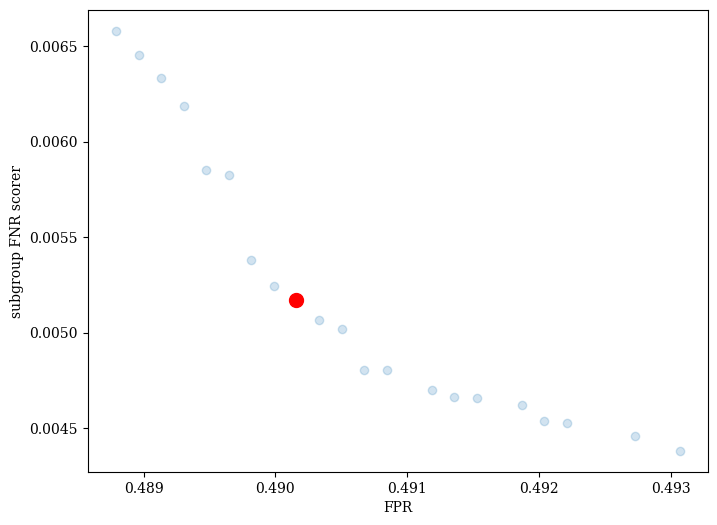

In [4]:
est.plot().show()

# visualize model set

`est.plot()` will return the Pareto front found during the run, with a red dot indicating the final chosen model. 
By default, Fomo uses the PseudoWeights method from pymoo to choose the final model, which produces a model near the centroid of the front. 

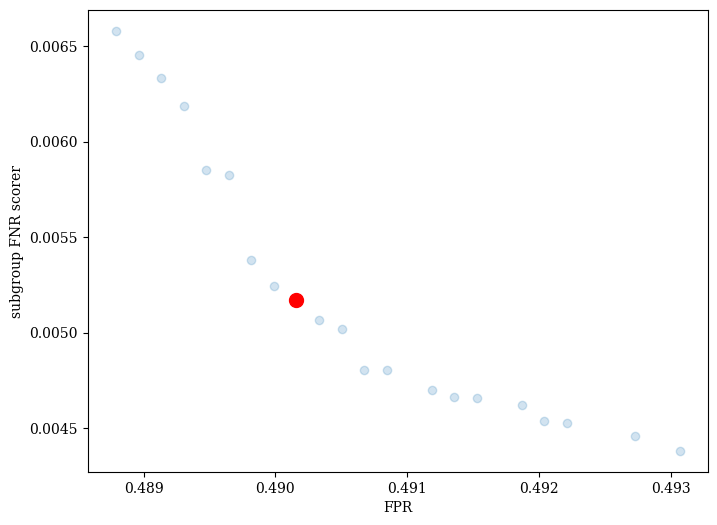

In [5]:
est.plot().show()

## picking with different strategies

We can also pick with other multi-criteria decision making strategies (MDCMs). 
Fomo supports the PseudoWeights, Compromise, and HighTradeoffPoints strategies from [pymoo](https://pymoo.org/mcdm). 

Here's an example of picking with the Compromise strategy.

Text(0.5, 1.0, 'Picking with PseudoWeights')

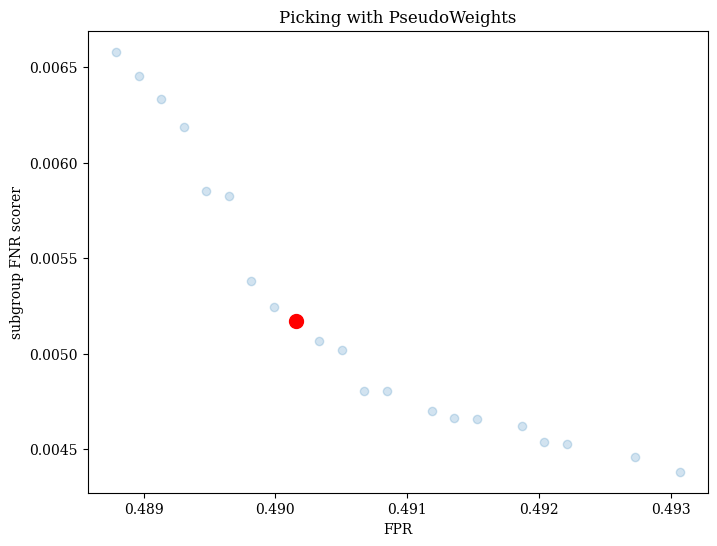

In [6]:
est.best_estimator_ = est.pick_best('PseudoWeights')
plot = est.plot()
plot.show()
plt.title('Picking with PseudoWeights')


Text(0.5, 1.0, 'Picking with Compromise')

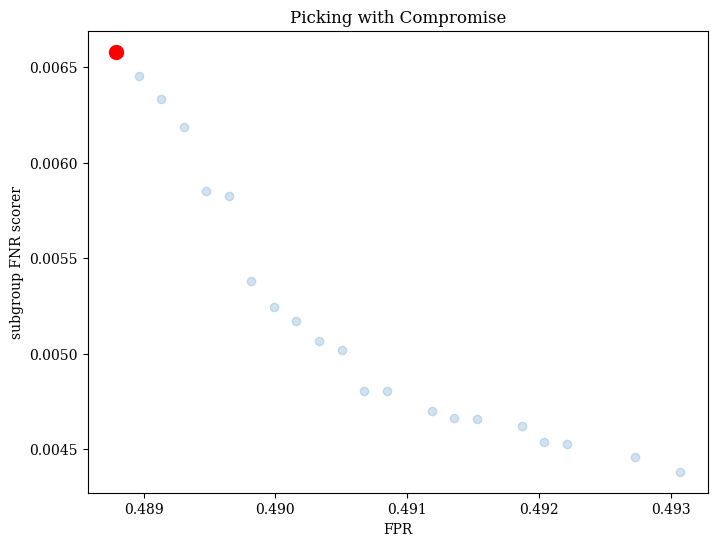

In [7]:
est.best_estimator_ = est.pick_best('Compromise')
plot2 = est.plot()
plot2.show()
plt.title('Picking with Compromise')


Here's an example of picking with the HighTradeoffPoints strategy.

Text(0.5, 1.0, 'Picking with HighTradeoffPoints')

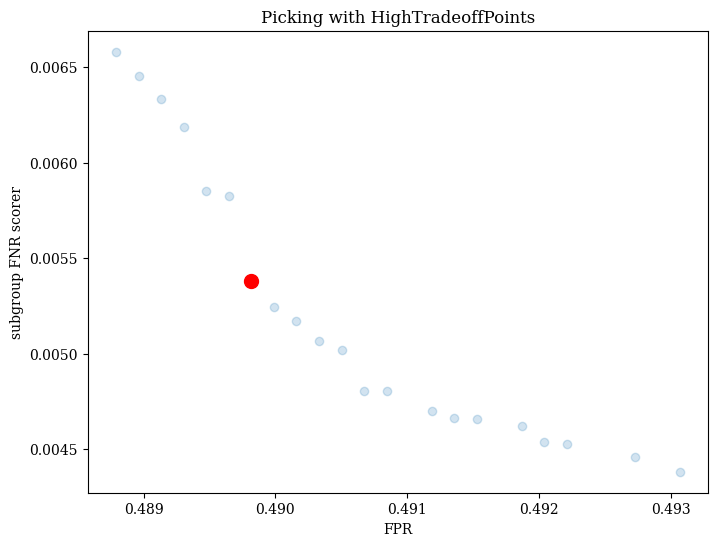

In [8]:
est.best_estimator_ = est.pick_best('HighTradeoffPoints')
plot3 = est.plot()
plot3.show()
plt.title('Picking with HighTradeoffPoints')